# Main Simuluation

### Main setup:

- Generate ground-truth 1-D latent paramater $\xi$.

- Generate a gene expression matrix of dimension with 1500 samples and 9000 genes:
    - Generate non-null variables based on $x_{i,j} = f_j(\xi_i) + \epsilon_{i,j}$
    - Each $f_j$ is selected from a template, and each template is repeated several times (see below) 
    - The known non-null templates are monotonic. 
    - Each $\epsilon_{i, j}$ is chosen to be drawn from a $\mathcal{N}(0, \sigma)$ ($\sigma$: noise level).
    - Generate the remaining as null variables based on a uniform (0,1) which is independent of $\xi$.

- Run the two parallel methods (P-ALOE and G-ALOE)

- Evalute the $\text{corr}(\xi, \hat{\xi})$ using the output of the two algorithms (which uses  known and the additionally selected features)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
print(logging.__file__)
print(mpl.__file__)

/home/users/jjzhu/.pyenv/versions/3.6.1/lib/python3.6/logging/__init__.py
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/matplotlib/__init__.py


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr
# sns.despine()
logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

from sim_utils import get_sim_params, get_regime_info, load_regime_results
from plot_utils import plot_regime_method_comparison, plot_sub_regime
from plot_utils import check_spike_groups, check_example_noise_matrix
from io_utils import save_data_to_file, load_data_from_file

def summarize_pipeline(sim_id, sparsity):
    params = get_sim_params(sim_id)
    logger.info(params)
    copy_per_template = params["z_param"]["n_repetitions"] * len(params["z_param"]["rel_noise_list"])
    logger.info("Copy per template for known non-nulls: {}".format(copy_per_template))
    copy_per_template = int(sparsity * params['target_vars'] / len(params["x_param"]["spike_grp"]))
    logger.info("Copy per template for unknown non-nulls: {}".format(copy_per_template))
    logger.info("Non-null sparsity: {}".format(sparsity))
    check_spike_groups(sim_id)

def get_fpath(sim_id, sparsity, method_group):
    DIR = get_sim_params(sim_id)["sim_dir"]
    DIR = os.path.join(DIR, "plot_data")
    os.makedirs(DIR, exist_ok=True)
    fn = os.path.join(DIR, "{}_{}_{}.csv".format(sim_id, sparsity, method_group))
    return fn 

def save_sparsity_df(sim_id, sparsity, method_group):
    if method_group == "aloe":
        methods=["graph", "pc"]
    elif method_group == "unsup":
        methods=['unsup_graph', 'unsup_pc']
    else:
        assert "{} not recognized".format(method_group)
        
    # load everything first
    df_regime = get_regime_info(sim_id) 
    df_result = load_regime_results(sim_id)
    df_result = pd.merge(df_result, df_regime, how="left", on="Regime")
    plt_df = df_result[df_result["sparsity"] == sparsity].copy()
    plt_df = plt_df[plt_df["Method"].isin(methods)]
    method_list = list(plt_df["Method"].copy())
    name_map = {
        "unsup_pc": "PCA",
        "unsup_graph": "Graph",
        "pc": "P-ALOE", 
        "graph": "G-ALOE"
    }
    for i in range(len(method_list)):
        if method_list[i] in  name_map:
            method_list[i] = name_map[method_list[i]]
    plt_df["Method"] = method_list
    logger.info("Keeping: {}".format(plt_df.shape))
    fn = get_fpath(sim_id, sparsity, method_group)
    save_data_to_file(plt_df, fn, "csv")
    logger.info("Saved plot data to {}".format(fn))
    return plt_df

def load_sparsity_df(sim_id, sparsity, method_group):
    fn = get_fpath(sim_id, sparsity, method_group)
    plt_df = load_data_from_file(fn, "csv")
    logger.info("Loaded plot data from {}".format(fn))    
    return plt_df
    
def plot_results(sim_id, sparsity, plain=False, FDIR=None):
    params = get_sim_params(sim_id)
    params["plot_metrics"] = ["Corr", "Power", "FDP"]
    params["plot_noise_lev"] = [0.1, 0.5, 1, 1.5, 2, 3][::-1]
    aloe_df = load_sparsity_df(sim_id, sparsity,  method_group="aloe")
    unsup_df = load_sparsity_df(sim_id, sparsity, method_group="unsup")
    if plain:
        if FDIR:
            fn = os.path.join(FDIR, "{}_aloe_{}_plain.pdf".format(sim_id, sparsity))
        else:
            fn = None
        plot_regime_method_comparison(aloe_df, params, plain=plain, fn=fn, q_lim=[0.845, 1.005])
        
    # new plot for paper
    metrics = params["plot_metrics"]
    noise_lev = params["plot_noise_lev"]
    alpha = params['alpha']
    
    pal = {"PCA": "#DB7000", "Graph": "#008E2D"}
    fig, axes = plt.subplots(1, len(metrics), 
                             figsize=[3.3*len(metrics), 2.8])
    for i_ax, met in enumerate(metrics):
        ax = axes[i_ax]
        plot_sub_regime(aloe_df, ax, met, noise_lev, "Set1", alpha, plain=plain)
        plot_sub_regime(unsup_df, ax, met, noise_lev, pal, alpha, plain=plain)
        if not plain:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
    if FDIR:
        if plain:
            fn = os.path.join(FDIR, "{}_unsup_comp_{}_plain.pdf".format(sim_id, sparsity))
        else:
            fn = os.path.join(FDIR, "{}_unsup_comp_{}.pdf".format(sim_id, sparsity))
    else:
        fn = None
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()
    if (not plain) and FDIR:
        fn = os.path.join(FDIR, "{}_matrix_{}.png".format(sim_id, sparsity))
    else:
        fn = None
    check_example_noise_matrix(sim_id, sparsity, fn=fn)

### Save data for plotting


In [3]:
for sparsity in [0.1, 0.05, 0.2]:
    for sim_id in ["main_sim_4", "main_sim_5"]:
        for method_group in ["aloe", "unsup"]:
            save_sparsity_df(sim_id, sparsity, method_group)

[feat_viz INFO] sim. dir.: /share/PI/sabatti/feat_viz/main_sim_4
[feat_viz INFO] Loaded all data: (7200, 6)
[feat_viz INFO] Keeping: (1200, 9)
[feat_viz INFO] Saved plot data to /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.1_aloe.csv
[feat_viz INFO] sim. dir.: /share/PI/sabatti/feat_viz/main_sim_4
[feat_viz INFO] Loaded all data: (7200, 6)
[feat_viz INFO] Keeping: (1200, 9)
[feat_viz INFO] Saved plot data to /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.1_unsup.csv
[feat_viz INFO] sim. dir.: /share/PI/sabatti/feat_viz/main_sim_5
[feat_viz INFO] Loaded all data: (7200, 6)
[feat_viz INFO] Keeping: (1200, 9)
[feat_viz INFO] Saved plot data to /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.1_aloe.csv
[feat_viz INFO] sim. dir.: /share/PI/sabatti/feat_viz/main_sim_5
[feat_viz INFO] Loaded all data: (7200, 6)
[feat_viz INFO] Keeping: (1200, 9)
[feat_viz INFO] Saved plot data to /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.1_unsup.cs

## Performance under other regimes

- `main_sim_4`: correlated noise
- `main_sim_5`: independent noise
- `sparsity`: number of non-nulls (0.05, 0.1, 0.2)

[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.1_aloe.csv
[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.1_unsup.csv


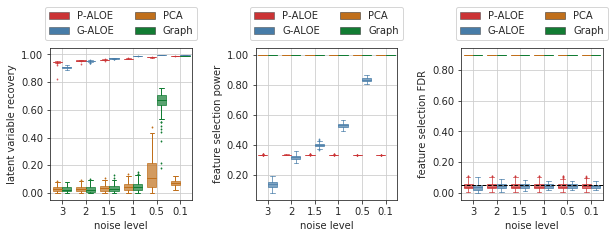

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 150, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


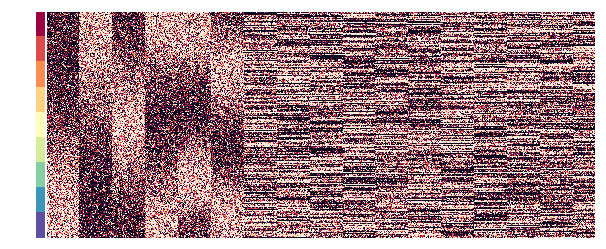

[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.1_aloe.csv
[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.1_unsup.csv


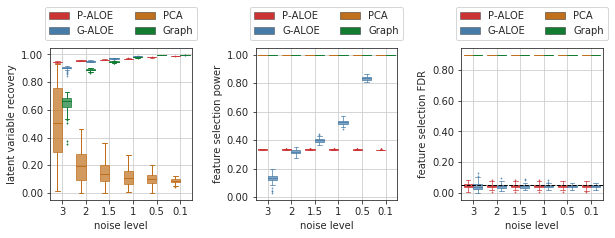

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 150, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0}


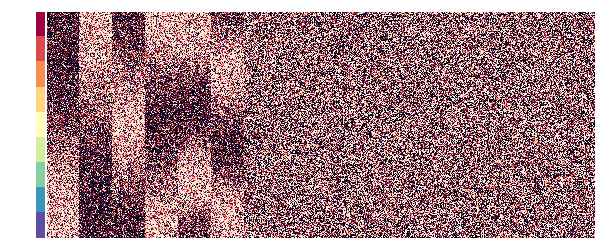

In [12]:
sparsity = 0.1
plot_results("main_sim_4", sparsity, plain=False)
plot_results("main_sim_5", sparsity, plain=False)

[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.2_aloe.csv
[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.2_unsup.csv


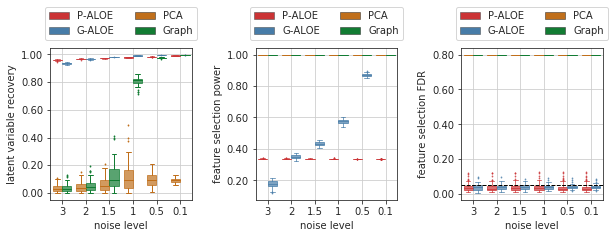

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 300, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


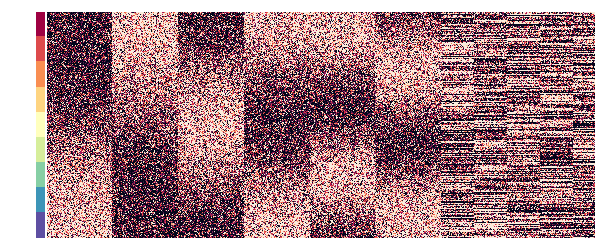

[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.2_aloe.csv
[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.2_unsup.csv


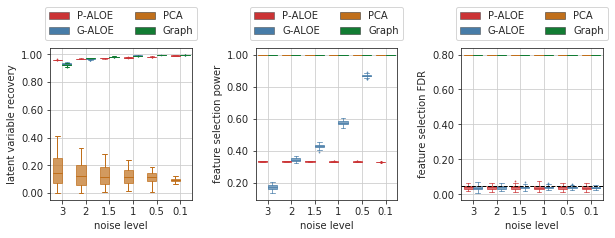

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 300, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0}


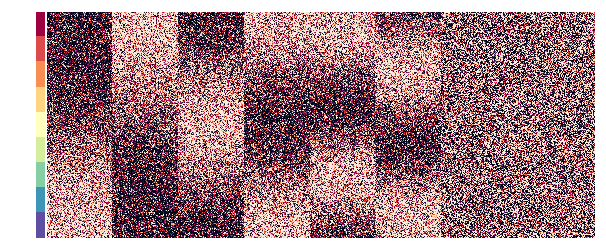

In [13]:
sparsity = 0.2
plot_results("main_sim_4", sparsity, plain=False)
plot_results("main_sim_5", sparsity, plain=False)

[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.05_aloe.csv
[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_4/plot_data/main_sim_4_0.05_unsup.csv


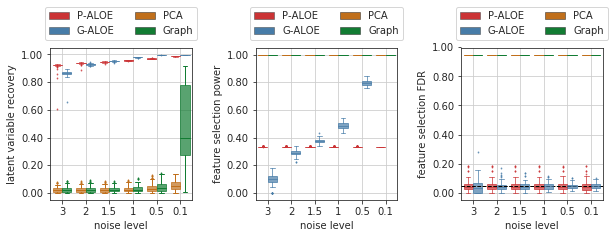

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 75, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


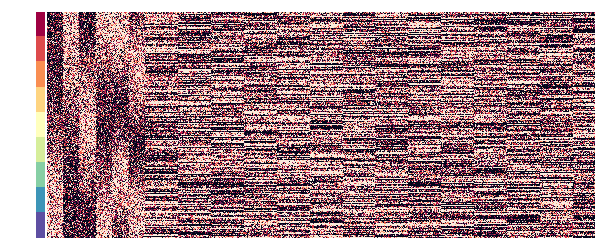

[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.05_aloe.csv
[feat_viz INFO] Loaded plot data from /share/PI/sabatti/feat_viz/main_sim_5/plot_data/main_sim_5_0.05_unsup.csv


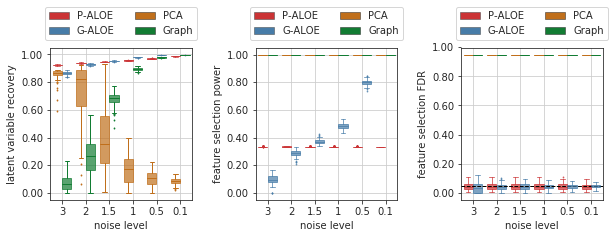

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 75, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0}


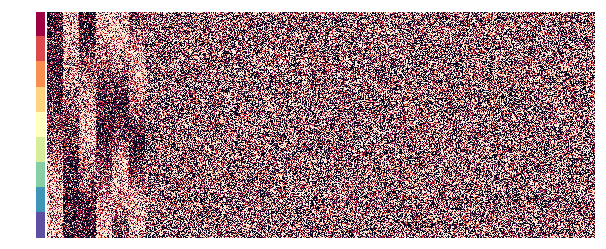

In [14]:
sparsity = 0.05
plot_results("main_sim_4", sparsity, plain=False)
plot_results("main_sim_5", sparsity, plain=False)

## Save Figures

[feat_viz INFO] {'seed': 1, 'n_samps': 1500, 'z_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 1, 'rel_noise_list': [1, 0.1]}, 'x_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': None, 'rel_noise_list': None}, 'n_trials': 100, 'noise_levs': [0.1, 0.5, 1, 1.5, 2, 3], 'sparsities': [0.05, 0.1, 0.2], 'target_vars': 9000, 'methods': ['unsup_pc', 'unsup_graph', 'pc', 'graph'], 'graph_k': 10, 'n_perms': 10000, 'alpha': 0.05, 'perm_method': 'pool', 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_4', 'save': True, 'check_skip': False, 'null_struct': {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}}
[feat_viz INFO] Copy per template for known non-nulls: 2
[feat_viz INFO] Copy per template for unknown non-nulls: 150
[feat_viz INFO] Non-null sparsity: 0.1


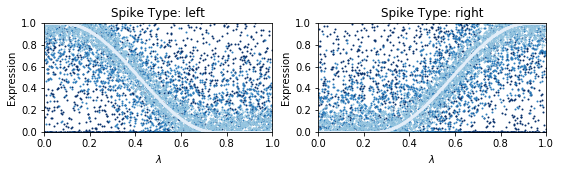

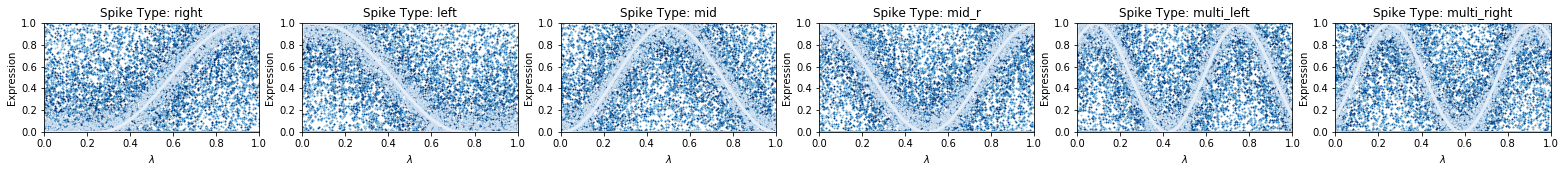

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_aloe_0.1_plain.pdf


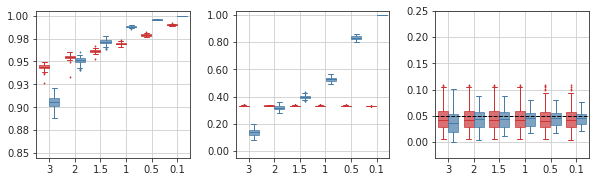

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_unsup_comp_0.1_plain.pdf


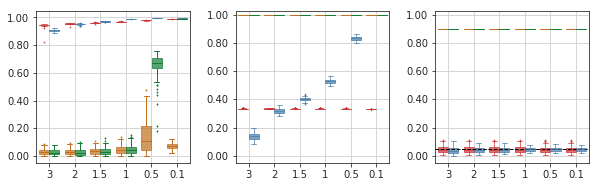

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 150, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


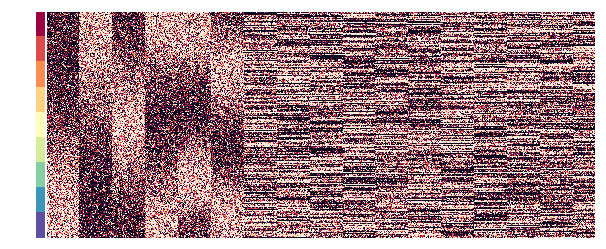

In [9]:
FDIR = "/share/PI/sabatti/feat_viz/main_figs"

sim_id = "main_sim_4"
sparsity = 0.1
summarize_pipeline(sim_id, sparsity)
plot_results(sim_id, sparsity, plain=True, FDIR=FDIR)

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_unsup_comp_0.1.pdf


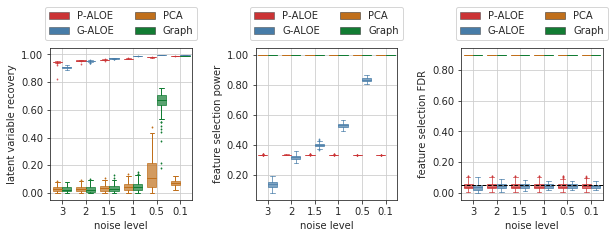

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 150, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_matrix_0.1.png


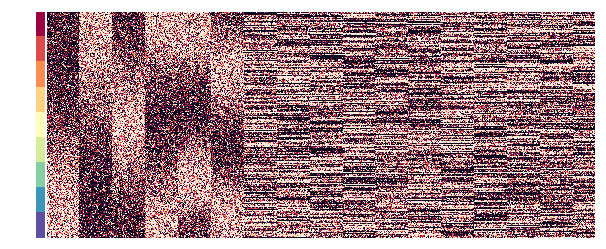

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_5_unsup_comp_0.1.pdf


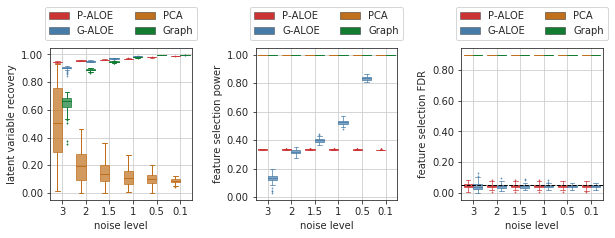

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 150, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_5_matrix_0.1.png


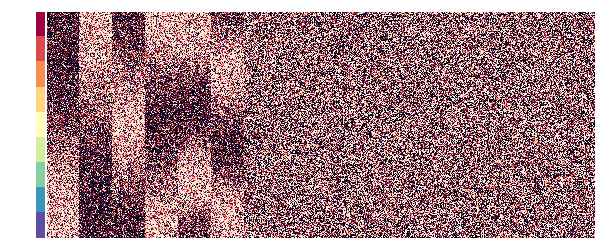

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_unsup_comp_0.05.pdf


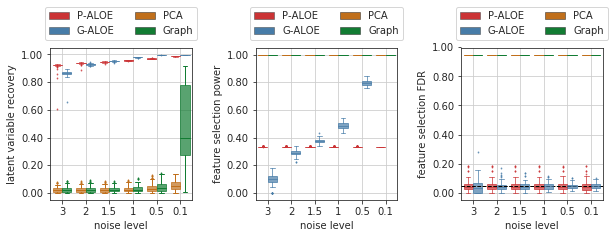

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 75, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_matrix_0.05.png


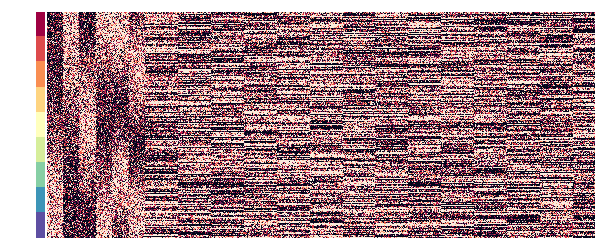

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_5_unsup_comp_0.05.pdf


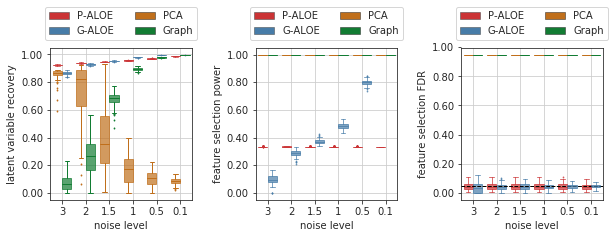

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 75, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_5_matrix_0.05.png


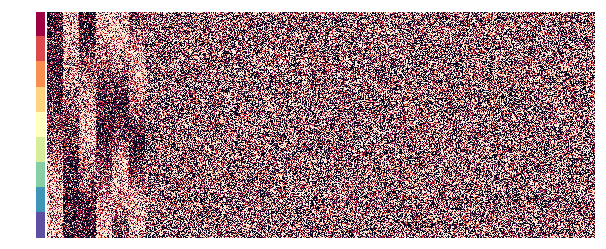

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_unsup_comp_0.2.pdf


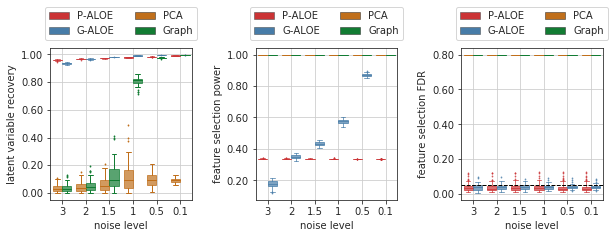

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 300, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_4_matrix_0.2.png


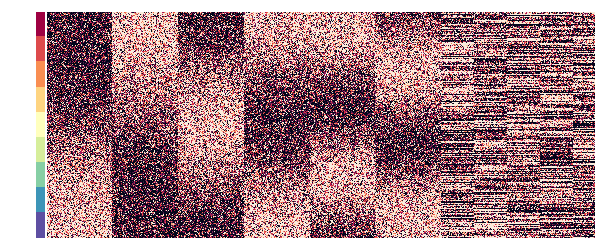

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_5_unsup_comp_0.2.pdf


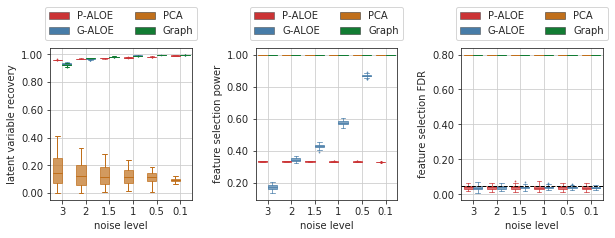

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 300, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0}
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_5_matrix_0.2.png


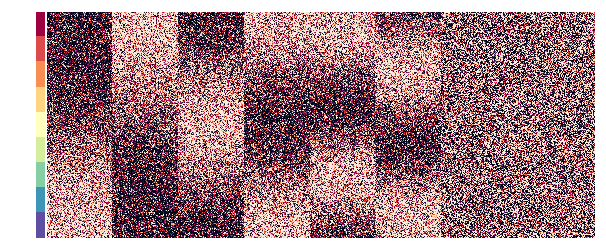

In [10]:
for sparsity in [0.1, 0.05, 0.2]:
    for sim in ["main_sim_4", "main_sim_5"]:
        plot_results(sim, sparsity, plain=False, FDIR=FDIR)

# Old (Unused) Simulation Data

[feat_viz INFO] {'seed': 1, 'n_samps': 1500, 'z_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 1, 'rel_noise_list': [1, 0.1]}, 'x_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': None, 'rel_noise_list': None}, 'n_trials': 100, 'noise_levs': [0.1, 0.5, 1, 1.5, 2, 3], 'sparsities': [0.01, 0.05, 0.1, 0.2], 'target_vars': 9000, 'methods': ['pc', 'graph'], 'graph_k': 10, 'n_perms': 10000, 'alpha': 0.05, 'perm_method': 'pool', 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_2', 'save': True, 'check_skip': False, 'null_struct': {}}
[feat_viz INFO] Copy per template for known non-nulls: 2


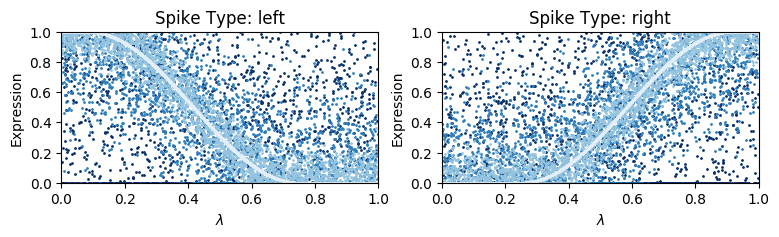

[feat_viz INFO] Copy per template for unknown non-nulls: 150
[feat_viz INFO] Non-null sparsity: 0.1


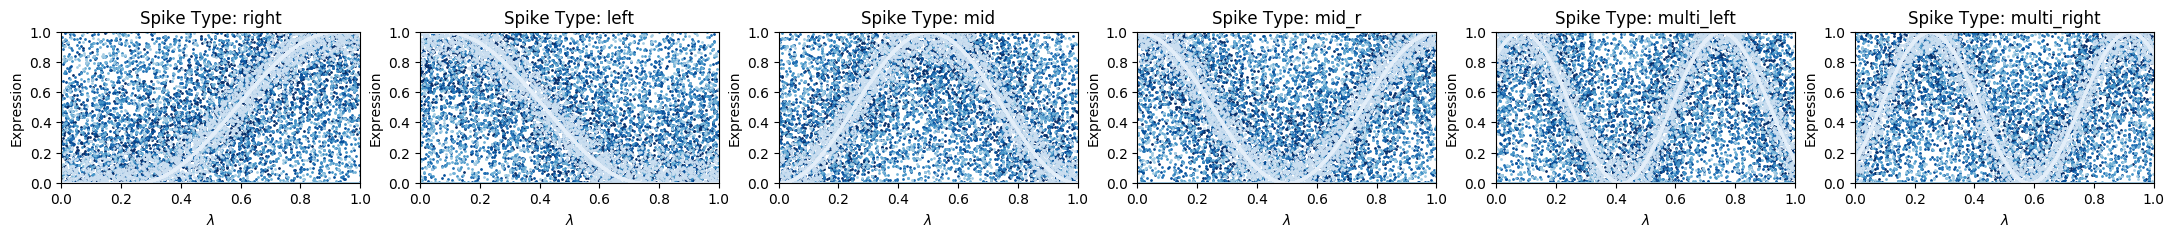

In [25]:
sim_id = "main_sim_2"
sparsity = 0.1
load_pipeline(sim_id, sparsity)

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/main_sim_full.pdf


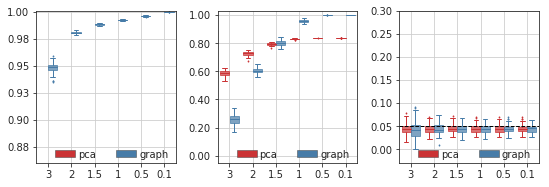

In [42]:
fn = os.path.join(FDIR, "main_sim_full.pdf")
plot_regime_method_comparison(plt_df, params, fn=fn, plain=True)

[feat_viz INFO] {'seed': 1, 'n_samps': 1500, 'z_param': {'spike_grp': ['left', 'right'], 'n_repetitions': 1, 'rel_noise_list': [1, 0.1]}, 'x_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': None, 'rel_noise_list': None}, 'n_trials': 100, 'noise_levs': [0.1, 0.5, 1, 1.5, 2, 3], 'sparsities': [0.05, 0.1, 0.2], 'target_vars': 9000, 'methods': ['unsup_pc', 'unsup_graph', 'pc', 'graph'], 'graph_k': 10, 'n_perms': 10000, 'alpha': 0.05, 'perm_method': 'pool', 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_4', 'save': True, 'check_skip': False, 'null_struct': {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}}
[feat_viz INFO] Copy per template for known non-nulls: 2


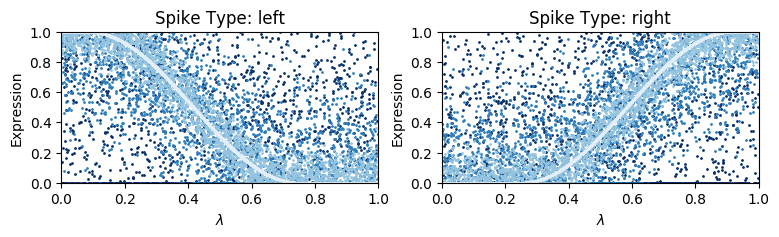

[feat_viz INFO] Copy per template for unknown non-nulls: 150
[feat_viz INFO] Non-null sparsity: 0.1


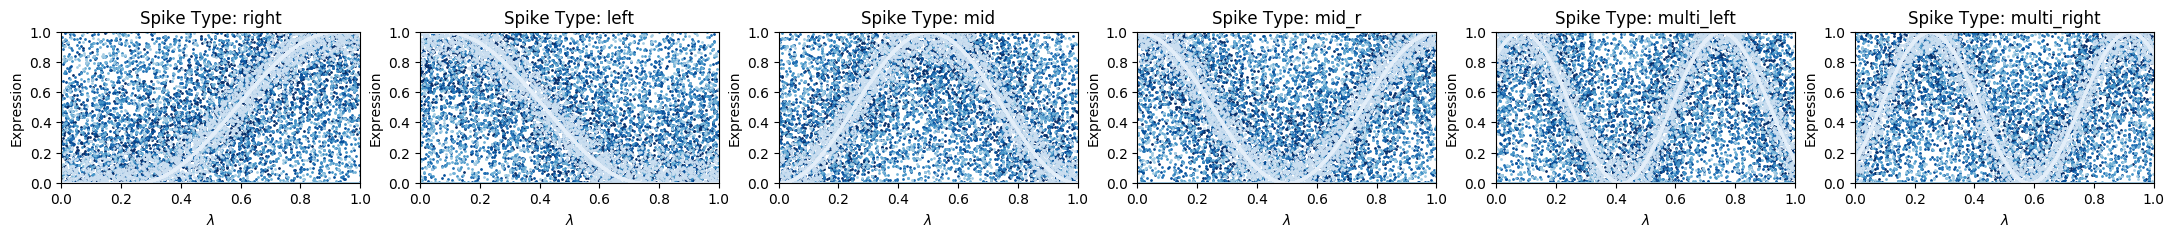

In [22]:
sim_id = "main_sim_4"
sparsity = 0.1
load_pipeline(sim_id, sparsity)